In [2]:
#| include: false 
from pyannote.core import notebook, Annotation, Timeline, Segment
from pyannote.metrics.errors.identification import IdentificationErrorAnalysis
from pyannote.metrics.diarization import DiarizationErrorRate
from rich import print
import numpy as np
np.set_printoptions(precision=2)

notebook.reset()
notebook.crop = Segment(0, 10)

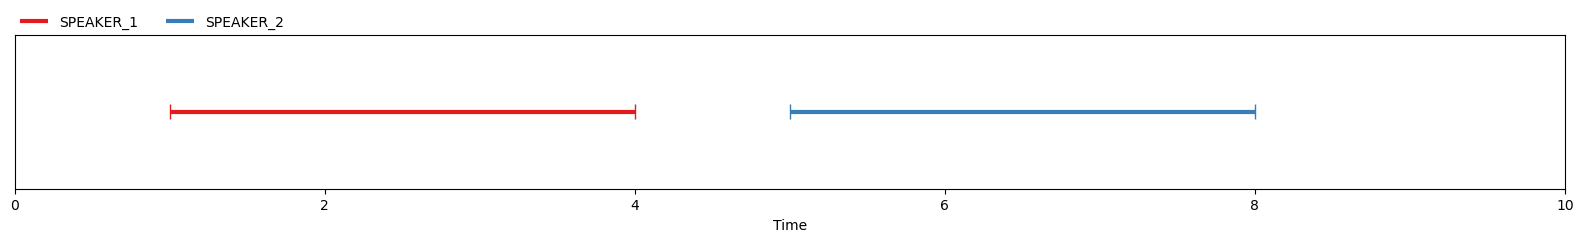

In [35]:
#| echo: false
reference = Annotation()
reference[Segment(1, 4)] = 'SPEAKER_1'
reference[Segment(5, 8)] = 'SPEAKER_2'
reference

Now, let's assume that an (automatic) speaker diarization system produces this hypothesis for the same conversation:

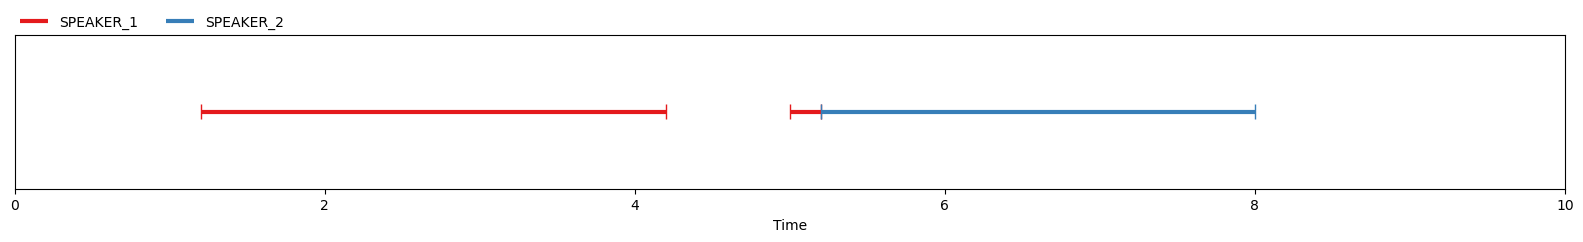

In [36]:
#| echo: false
hypothesis = Annotation()
hypothesis[Segment(1.2, 4.2)] = 'SPEAKER_1'
hypothesis[Segment(5.0, 5.2)] = 'SPEAKER_1'
hypothesis[Segment(5.2, 8.0)] = 'SPEAKER_2'
hypothesis

In [37]:
#| include: false
def compute_errors(reference, hypothesis):
    analysis = IdentificationErrorAnalysis()
    difference = analysis.difference(reference, hypothesis)
    difference = difference.subset([label for label in difference.labels() if label[0] == 'correct'], invert=True)
    return difference.rename_labels({label: label[0].upper() for label in difference.labels()})
errors = compute_errors(reference, hypothesis)

/Users/hbredin/miniconda3/envs/pyannote-mps/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


The system made three types of errors:

* _missed detection_, it missed the beginning of `SPEAKER_1` turn around time t=1s;
* _false alarm_: it marked `SPEAKER_1` has active when it is not, around time t=4s 
* _confusion_: it confused `SPEAKER_2` for `SPEAKER_1` around time t=5s

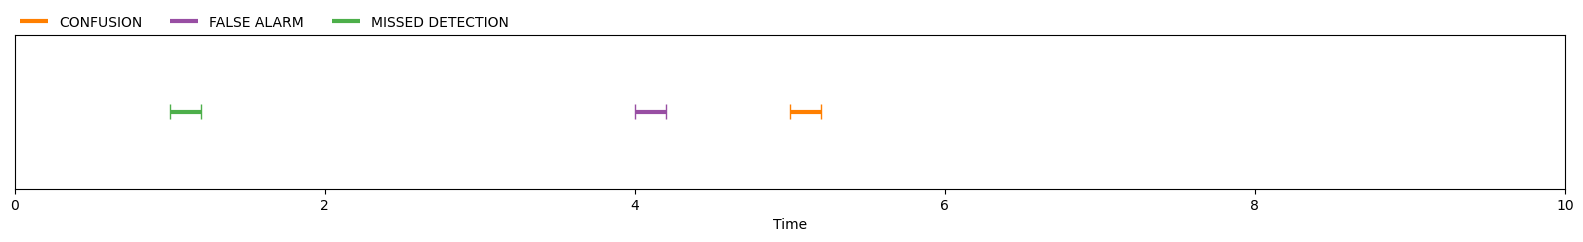

In [38]:
#| echo: false
errors

The most common metric used for evaluating speaker diarization systems is the _diarization error rate_ which is defined as the ratio between the total duration of this three types of errors divided by the total duration of speech according to the manual annotation:

$$\mbox{diarization error rate} = \frac{\mbox{missed detection} + \mbox{false alarm} + \mbox{confusion}}{\mbox{total duration of speech}}$$

which you can compute with [`pyannote.metrics`](https://pyannote.github.io/pyannote-metrics/) as follows:

In [7]:
metric = DiarizationErrorRate()
der = metric(reference, hypothesis)
print(f"DER = {100*der:.1f}%")

DER = 10.0%

A detailed duration breakdown of this value can be obtained using the `detailed=True` option:

In [8]:
print(metric(reference, hypothesis, detailed=True))

{
    'total': 6.0,
    'missed detection': 0.19999999999999996,
    'false alarm': 0.20000000000000018,
    'confusion': 0.20000000000000018,
    'correct': 5.6,
    'diarization error rate': 0.10000000000000005
}

The above equation becomes:

$$\mbox{diarization error rate} = \frac{\mbox{200ms} + \mbox{200ms} + \mbox{200ms}}{\mbox{6s}} = 10\%$$


## _"Forgiveness"_ collars

It is very difficult for (human) annotators to precisely define the start and end time of speaker turns... and even more so in presence of adverse acoustic conditions or overlapping speech. Therefore, the speaker diarization community came up with the notion of _"forgiveness collars"_: small regions (typically a few hundred milliseconds) centered on the start and end time of every single speaker turns during which systems are _forgiven_ for their mistakes. 

In the above conversation, _"250ms forgiveness collars"_ would look like this:

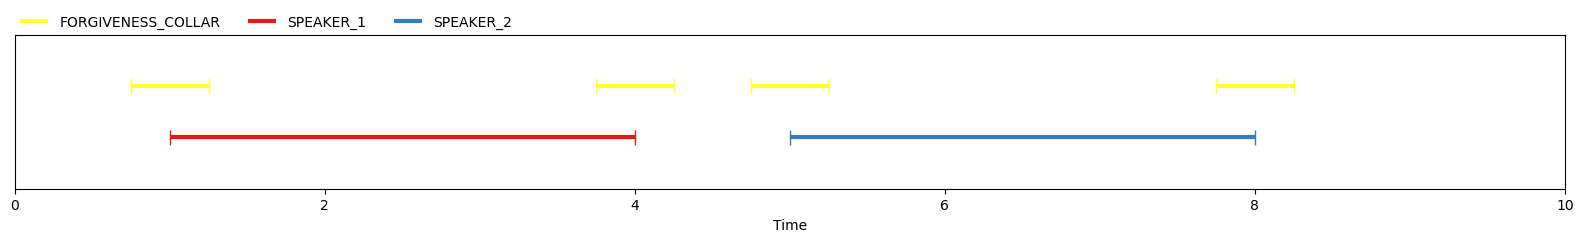

In [9]:
#| echo: false 
forgiveness_collars = Annotation()
forgiveness_collars[Segment(0.750, 1.250)] = "FORGIVENESS_COLLAR"
forgiveness_collars[Segment(3.750, 4.250)] = "FORGIVENESS_COLLAR"
forgiveness_collars[Segment(4.750, 5.250)] = "FORGIVENESS_COLLAR"
forgiveness_collars[Segment(7.750, 8.250)] = "FORGIVENESS_COLLAR"
reference.update(forgiveness_collars, copy=True)

Noticed how every single error made by the automatic system falls within the forgiveness collars?

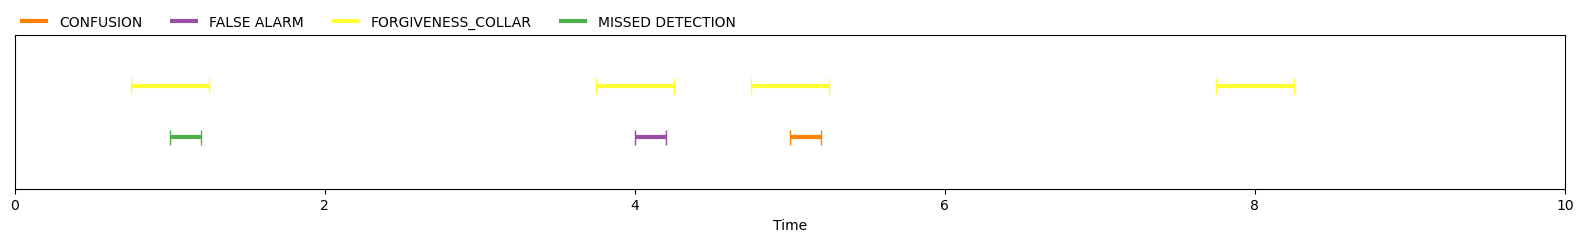

In [10]:
#| echo: false
errors.update(forgiveness_collars, copy=True)

Consequently, evaluating the very same system with forgiveness collars results in a perfect diarization error rate!

In [11]:
#| include: false
metric_with_collars = DiarizationErrorRate(collar=0.500)

In [12]:
der = metric_with_collars(reference, hypothesis)
print(f"DER (with collars) = {100*der:.1f}%")

DER (with collars) = 0.0%

No false alarm, no missed detection, no confusion, nothing!

In [13]:
print(metric_with_collars(reference, hypothesis, detailed=True))

{
    'total': 5.0,
    'missed detection': 0.0,
    'false alarm': 0.0,
    'confusion': 0.0,
    'correct': 5.0,
    'diarization error rate': 0.0
}

That is the whole point of collars: forgiving systems for making mistakes in regions were even humans cannot be 100\% correct. 

Seems reasonable, right? Right? RIGHT?

## I don't like collars! "250ms" collars are not what you think they are!

Did you notice that those _"250ms"_ collars actually are 500ms long? There! You have it! **The first reason I don't like collars!** 

For some reason, the speaker diarization community decided a long time ago that "250ms" collars actually are 500ms-long regions centered on speaker boundaries: 250ms on the left, 250ms on the right. This has been implemented like this since the good old `md-eval.pl` Perl (😱) script and [`nryant/dscore`](https://github.com/nryant/dscore) did a good job ensuring that their Python (🤩) version is [consistent](https://github.com/nryant/dscore/blob/824f126ae9e78cf889e582eec07941ffe3a7d134/scorelib/metrics.py#L406-L409) with it. 

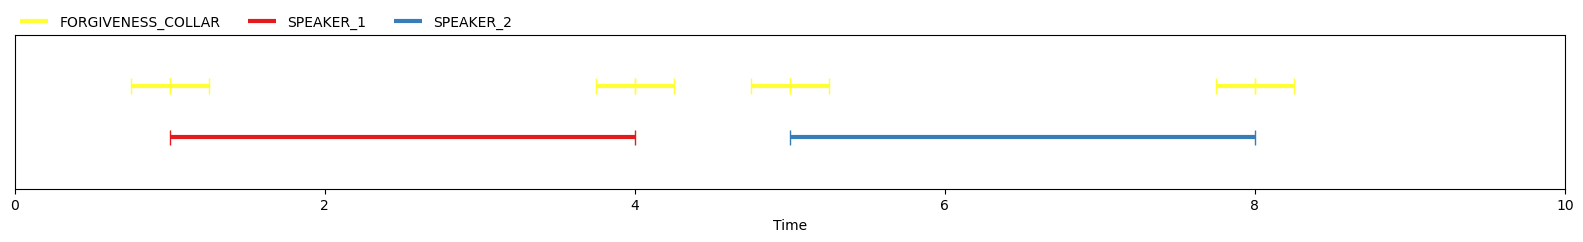

In [14]:
#| echo: false
forgiveness_collars_ = Annotation()
forgiveness_collars_[Segment(0.750, 1.000)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(1.000, 1.250)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(3.750, 4.000)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(4.000, 4.250)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(4.750, 5.000)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(5.000, 5.250)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(7.750, 8.000)] = "FORGIVENESS_COLLAR"
forgiveness_collars_[Segment(8.000, 8.250)] = "FORGIVENESS_COLLAR"
reference.update(forgiveness_collars_, copy=True)

When designing [`pyannote.metrics`](http://pyannote.github.io/pyannote-metrics/), I decided to make it clear from the beginning what the overall duration of the collar will be so [you should use `collar=0.5`](https://github.com/pyannote/pyannote-metrics/issues/63) to actually be consistent with `md-eval.pl` _"250ms"_ collar. This is how the above `metric_with_collars` has been instantiated:

In [15]:
metric_with_collars = DiarizationErrorRate(collar=0.500)

## I don't like collars! They depend on annotation guidelines!

A second reason I don't like collars is that the speaker diarization community somehow *hardcoded* this 250ms collar duration despite the fact that every benchmarking initiative gives different instructions to their pool of human annotators regarding how to annotate intra-speaker gaps:

* [DIHARD evaluation plan](https://dihardchallenge.github.io/dihard3/docs/third_dihard_eval_plan_v1.2.pdf) says that _"small pauses [shorter than] 200 ms by a speaker are not considered to be segmentation breaks and should be bridged into a single continuous segment"_;
* [VoxConverse guidelines](https://arxiv.org/abs/2007.01216) say that _"speech segments are split when pauses are greater than [250 ms]"_;
* [Albayzin 2022 evaluation plan](http://catedrartve.unizar.es/reto2022/SDIAC2022_Evalplan.pdf) goes even further by requesting that _"consecutive segments of the same speaker with a silence of less that 2 seconds [...] are considered as a single segment"_.


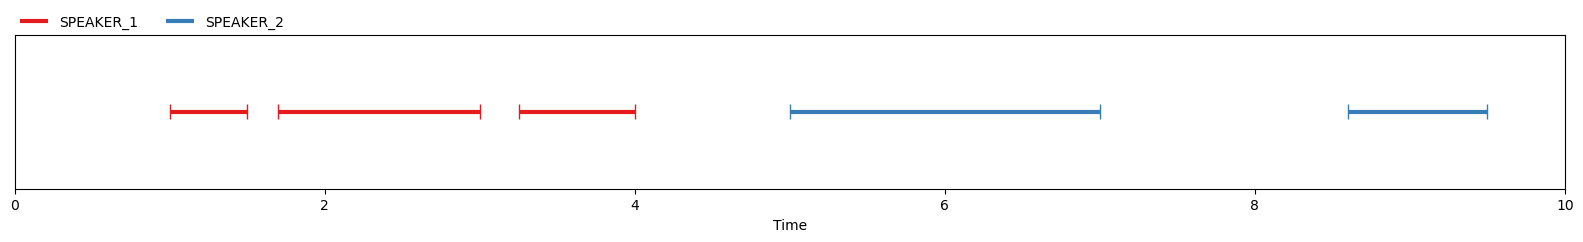

In [16]:
#| echo: false
reference = Annotation()
reference[Segment(1, 1.5)] = 'SPEAKER_1'
reference[Segment(1.7, 3)] = 'SPEAKER_1'
reference[Segment(3.25, 4)] = 'SPEAKER_1'
reference[Segment(5, 7)] = 'SPEAKER_2'
reference[Segment(8.6, 9.5)] = 'SPEAKER_2'
reference

For the above conversation, *DIHARD* guidelines would lead to the following "reference" annotation:

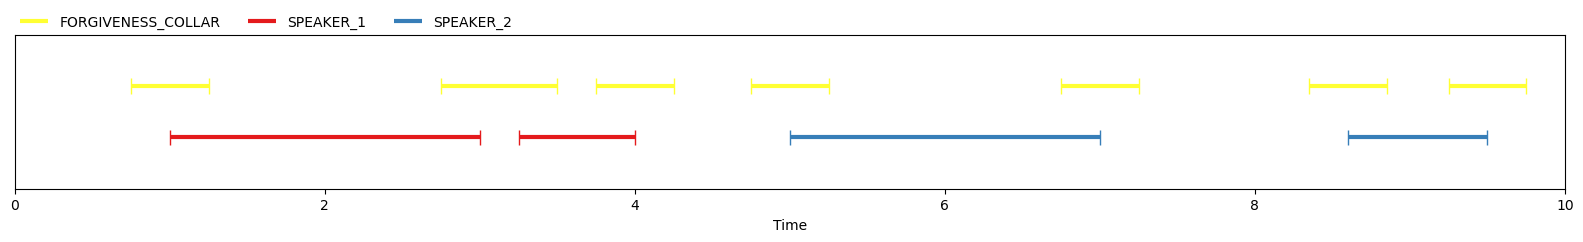

In [17]:
#| echo: false
dihard = Annotation()
dihard[Segment(1, 3)] = 'SPEAKER_1'
dihard[Segment(3.25, 4)] = 'SPEAKER_1'
dihard[Segment(5, 7)] = 'SPEAKER_2'
dihard[Segment(8.6, 9.5)] = 'SPEAKER_2'

dihard_with_collars = dihard.copy()
dihard_with_collars[Segment(0.75, 1.25)] = "FORGIVENESS_COLLAR"
dihard_with_collars[Segment(2.75, 3.50)] = "FORGIVENESS_COLLAR"
dihard_with_collars[Segment(3.75, 4.25)] = "FORGIVENESS_COLLAR"
dihard_with_collars[Segment(4.75, 5.25)] = "FORGIVENESS_COLLAR"
dihard_with_collars[Segment(6.75, 7.25)] = "FORGIVENESS_COLLAR"
dihard_with_collars[Segment(8.35, 8.85)] = "FORGIVENESS_COLLAR"
dihard_with_collars[Segment(9.25, 9.75)] = "FORGIVENESS_COLLAR"
dihard_with_collars

With *VoxConverse* guidelines, it would look like this:

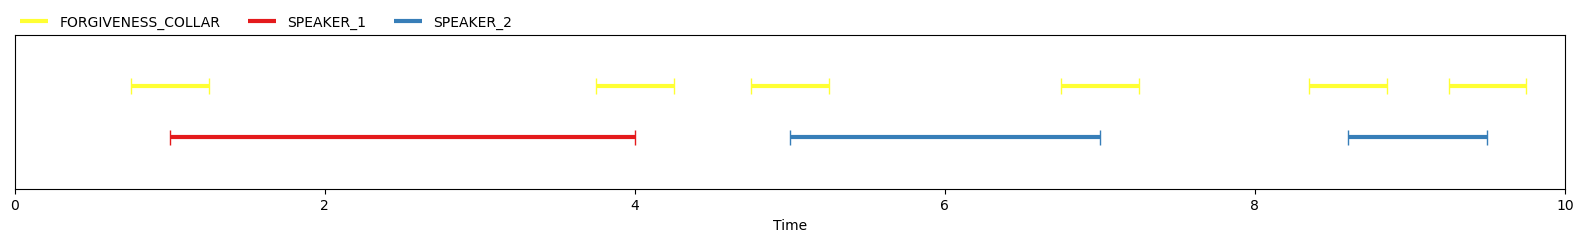

In [18]:
#| echo: false
voxconverse = Annotation()
voxconverse[Segment(1, 4)] = 'SPEAKER_1'
voxconverse[Segment(5, 7)] = 'SPEAKER_2'
voxconverse[Segment(8.6, 9.5)] = 'SPEAKER_2'

voxconverse_with_collars = voxconverse.copy()
voxconverse_with_collars[Segment(0.75, 1.25)] = "FORGIVENESS_COLLAR"
voxconverse_with_collars[Segment(3.75, 4.25)] = "FORGIVENESS_COLLAR"
voxconverse_with_collars[Segment(4.75, 5.25)] = "FORGIVENESS_COLLAR"
voxconverse_with_collars[Segment(6.75, 7.25)] = "FORGIVENESS_COLLAR"
voxconverse_with_collars[Segment(8.35, 8.85)] = "FORGIVENESS_COLLAR"
voxconverse_with_collars[Segment(9.25, 9.75)] = "FORGIVENESS_COLLAR"
voxconverse_with_collars

Now, let's compare those two "reference" annotations, using DIHARD as reference and VoxConverse as hypothesis, and vice-versa, with and without collars:

In [19]:
(metric_with_collars(dihard, voxconverse), metric_with_collars(voxconverse, dihard))

(0.0, 0.056818181818181816)

In [20]:
(metric(dihard, voxconverse), metric(voxconverse, dihard))

(0.04424778761061947, 0.0423728813559322)

Diarization error rates are much more stable without collars! 

**Full disclosure**: I agree that this example is 100% made up and a more in-depth analysis should be performed at a larger scale but still... I don't like collars!

You might argue that those first two reasons why I don't like collars might be anecdotal (and you might actually be right).

But, brace yourself, I kept the best for the end! 

## I don't like collars! They don't play well with overlapping speech

As automatic speaker diarization systems are getting better and better, diarization error rates on standard benchmarks are getting dangerously close to zero: the winning team of the last VoxSRC 2022 challenge reached a DER (with "250ms" collars) of 4.7\% while [pyannote.audio pipeline](https://huggingface.co/pyannote/speaker-diarization/blob/VoxSRC2022/README.md) reaches 5.6\%. 

In [21]:
from pyannote.database.util import load_rttm
references = load_rttm("voxconverse.test.manual.rttm")
hypotheses = load_rttm("voxconverse.test.auto.rttm")

In [22]:
metric = DiarizationErrorRate()
metric_with_collars = DiarizationErrorRate(collar=0.500)

for uri in references:
    metric(references[uri], hypotheses[uri])
    metric_with_collars(references[uri], hypotheses[uri])

/Users/hbredin/miniconda3/envs/pyannote-mps/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [23]:
abs(metric)

0.1039335843033163

In [24]:
abs(metric_with_collars)

0.0574707146501239

In [25]:
from pyannote.core import Annotation, Timeline
def to_overlap(annotation: Annotation) -> Annotation:
    """Get overlapped speech regions

    Parameters
    ----------
    annotation : Annotation
        Speaker annotation.

    Returns
    -------
    overlap : Annotation
        Overlapped speech annotation.
    """

    overlap = Timeline(uri=annotation.uri)
    for (s1, t1), (s2, t2) in annotation.co_iter(annotation):
        l1 = annotation[s1, t1]
        l2 = annotation[s2, t2]
        if l1 == l2:
            continue
        overlap.add(s1 & s2)
    return overlap.support().to_annotation(generator="string", modality="overlap")

In [26]:
import random
def remove_overlap(annotation: Annotation) -> Annotation:
    
    overlap = Timeline(uri=annotation.uri)
    for (s1, t1), (s2, t2) in annotation.co_iter(annotation):
        l1 = annotation[s1, t1]
        l2 = annotation[s2, t2]
        if l1 == l2:
            continue
        overlap.add(s1 & s2)
    
    no_overlap = overlap.gaps(support=annotation.get_timeline().extent())
    
    modified_annotation = annotation.crop(no_overlap)
    for segment in overlap:
        label = random.choice(annotation.crop(segment).labels())
        modified_annotation[segment] = label
    return modified_annotation

In [27]:
modified_hypotheses = {uri: remove_overlap(hypotheses[uri]) for uri in hypotheses}

In [28]:
metric = DiarizationErrorRate()
metric_with_collars = DiarizationErrorRate(collar=0.500)

for uri in references:
    metric(references[uri], modified_hypotheses[uri])
    metric_with_collars(references[uri], modified_hypotheses[uri])

/Users/hbredin/miniconda3/envs/pyannote-mps/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [29]:
abs(metric)

0.11150866672449616

In [30]:
abs(metric_with_collars)

0.06293896525542539

In [31]:
0.06304432936371232 - 0.0574707146501239

0.005573614713588422

In [32]:
0.1115695191642017 - 0.1039335843033163

0.007635934860885402

In [33]:
(0.1115695191642017 - 0.1039335843033163)/0.1115695191642017

0.06844104839823917

In [ ]:
Not dealing overlap is only penalize

In [ ]:
(0.06304432936371232 - 0.0574707146501239) * 100

0.5573614713588422

In [34]:
aepyx = voxconverse['aepyx']
aepyx

KeyError: 'a'

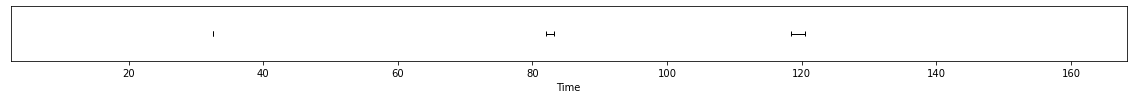

In [ ]:
to_overlap(aepyx).get_timeline()

In [ ]:
def amount_of_overlap(annotation: Annotation) -> float:
    overlap = to_overlap(annotation)
    return sum(segment.duration for segment, _ in overlap.itertracks()) 

In [ ]:
amount_of_overlap(aepyx)

3.3899999999999864

In [ ]:
def with_collar(annotation: Annotation) -> Annotation:
    from pyannote.metrics.diarization import DiarizationErrorRate
    metric = DiarizationErrorRate()
    return metric.uemify(annotation, annotation, collar=0.5)[0]

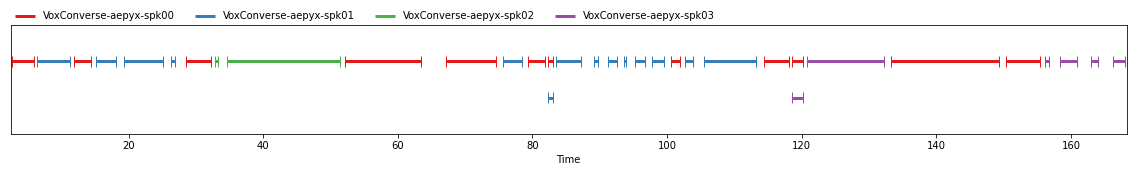

In [ ]:
with_collar(aepyx)

In [ ]:
amount_of_overlap(with_collar(aepyx))

2.329999999999984

In [ ]:
raw_overlap = sum(amount_of_overlap(reference) for _, reference in voxconverse.items())
raw_overlap

4283.1200000000035

In [ ]:
overlap_with_collar = sum(amount_of_overlap(with_collar(reference)) for _, reference in voxconverse.items())
overlap_with_collar

2031.489999999998

In [ ]:
def amount_of_speech(annotation: Annotation) -> float:
    return sum(segment.duration for segment, _ in annotation.itertracks())

In [ ]:
raw_speech = sum(amount_of_speech(reference) for _, reference in voxconverse.items())
raw_speech

144792.88

In [ ]:
speech_with_collar = sum(amount_of_speech(with_collar(reference)) for _, reference in voxconverse.items())
speech_with_collar

/Users/hbredin/miniconda3/envs/pyannote/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


130955.40999999993

In [ ]:
raw_ratio = raw_overlap / raw_speech
print(f"{100*raw_ratio:.2f}%")

2.96%

{{raw_ratio}}

In [ ]:
ratio_with_collar = overlap_with_collar / speech_with_collar
print(f"{100*ratio_with_collar:.2f}%")

1.55%

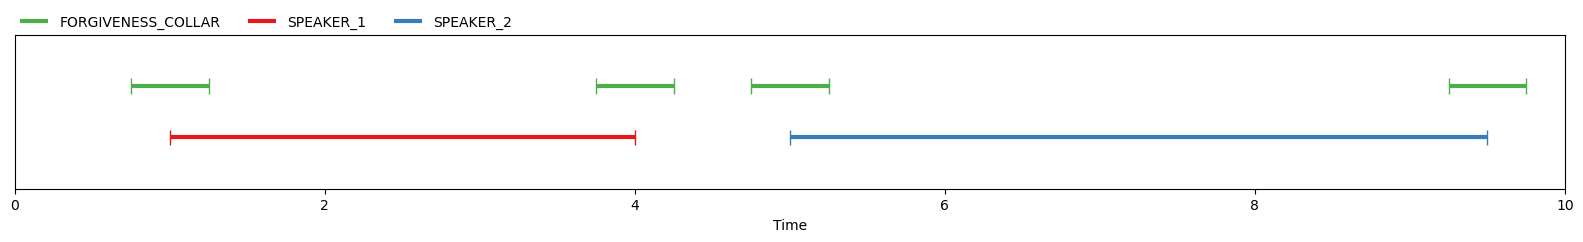

In [ ]:
#| echo: false
albayzin = Annotation()
albayzin[Segment(1, 4)] = 'SPEAKER_1'
albayzin[Segment(5, 9.5)] = 'SPEAKER_2'

albayzin_with_collars = albayzin.copy()
albayzin_with_collars[Segment(0.75, 1.25)] = "FORGIVENESS_COLLAR"
albayzin_with_collars[Segment(3.75, 4.25)] = "FORGIVENESS_COLLAR"
albayzin_with_collars[Segment(4.75, 5.25)] = "FORGIVENESS_COLLAR"
albayzin_with_collars[Segment(9.25, 9.75)] = "FORGIVENESS_COLLAR"
albayzin_with_collars